# Loading the libraries

In [63]:
from glob import glob
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import smogn

# Loading the file

In [38]:
abnormal_train_file_path= glob('nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/abnormal/train/*.edf')
abnormal_test_file_path= glob('nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/abnormal/eval/*.edf')
normal_train_file_path= glob('nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/normal/train/*.edf')
normal_test_file_path= glob('nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/normal/eval/*.edf')


# Getting length of file

In [39]:
print("Total no. of abnormal train file : " + str(len(abnormal_train_file_path)))
print("Total no. of abnormal test file : " + str(len(abnormal_test_file_path)))
print("Total no. of normal train file : " + str(len(normal_train_file_path)))
print("Total no. of normal test file : " + str(len(normal_test_file_path)))

Total no. of abnormal train file : 355
Total no. of abnormal test file : 90
Total no. of normal train file : 1877
Total no. of normal test file : 89


# Reading the CSV file

In [40]:
all_csv_data = pd.read_csv("./nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/Labels.csv")
csv_data_80 = pd.read_csv("./samples_80/sample80.csv")

In [41]:
all_csv_data # displaying the data

recordname     label  age         gender    loc
0     0000001.edf    normal   22  not specified  train
1     0000002.edf  abnormal   12         female  train
2     0000003.edf    normal   37           male  train
3     0000004.edf  abnormal   12           male  train
4     0000005.edf    normal   40           male  train
...           ...       ...  ...            ...    ...
2412  0002413.edf    normal   40           male  train
2413  0002414.edf  abnormal    5           male  train
2414  0002415.edf    normal   11         female  train
2415  0002416.edf  abnormal    3         female  train
2416  0002417.edf  abnormal   10           male  train

[2417 rows x 5 columns]

In [42]:
trained_df = all_csv_data[all_csv_data['loc']=='train']
len(trained_df)

2232

In [43]:
trained_df.gender.value_counts()

male             1481
female            750
not specified       1
Name: gender, dtype: int64

In [44]:
abnormal_train_file_path[0] # viewing the path

'nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/abnormal/train\\0000002.edf'

# Adding path to the CVS labels file

In [45]:
# filter_file = []
def add_file_path(data):
    record_name = [name.split("\\")[1] for name in data]
    file_path =   [name for name in data]
    data_frame = pd.DataFrame({'record_name':record_name,'data_file_path':file_path})
    filter_file = all_csv_data[all_csv_data.recordname.isin(record_name)]
    filter_file.reset_index(inplace=True)
       
    filter_file['file_path'] = data_frame.loc[data_frame['record_name']==filter_file['recordname'],'data_file_path']
    
    return filter_file
    

In [46]:
data1 = add_file_path(normal_train_file_path)
data2 = add_file_path(abnormal_train_file_path)
data3 = add_file_path(abnormal_test_file_path)
data4 = add_file_path(normal_test_file_path)

C:\Users\acer\AppData\Local\Temp\ipykernel_16548\2758272187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_file['file_path'] = data_frame.loc[data_frame['record_name']==filter_file['recordname'],'data_file_path']
C:\Users\acer\AppData\Local\Temp\ipykernel_16548\2758272187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_file['file_path'] = data_frame.loc[data_frame['record_name']==filter_file['recordname'],'data_file_path']
C:\Users\acer\AppData\Local\Temp\ipykernel_16548\2758272187.py

# Creating main dataset

In [48]:
all_data = [data1,data2,data3,data4] # merging data1,data2,data3,data4 in a list
main_data = pd.concat(all_data) # concating and converting list (all_data) into dataframe

In [49]:
type(main_data)
main_data

index   recordname   label  age         gender    loc  \
0       0  0000001.edf  normal   22  not specified  train   
1       2  0000003.edf  normal   37           male  train   
2       4  0000005.edf  normal   40           male  train   
3       5  0000006.edf  normal   38         female  train   
4       6  0000007.edf  normal   28           male  train   
..    ...          ...     ...  ...            ...    ...   
84   2365  0002366.edf  normal   22           male   eval   
85   2374  0002375.edf  normal   28           male   eval   
86   2383  0002384.edf  normal   60           male   eval   
87   2405  0002406.edf  normal    1           male   eval   
88   2406  0002407.edf  normal    6           male   eval   

                                            file_path  
0   nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
1   nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2   nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
3   nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
4   nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
..                                                ...  
84  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
85  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
86  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
87  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
88  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  

[2411 rows x 7 columns]

In [50]:
# main_data.drop('level_0',axis=1,inplace=True)
main_data.drop('index',axis=1,inplace=True)
main_data.reset_index(inplace=True)

In [51]:
main_data['file_path'][0]

'nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/normal/train\\0000001.edf'

In [52]:
# pd.set_option('display.max_row', None)

# Exploratory Data Analysis(Visualization)

In [53]:
raw = mne.io.read_raw_edf(main_data['file_path'][0],preload= True)
print(raw.info)
# all_file_path

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 39999  =      0.000 ...   199.995 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2021-04-10 15:43:59 UTC
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
>


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Using matplotlib as 2D backend.


C:\Users\acer\AppData\Local\Temp\ipykernel_16548\3353747735.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


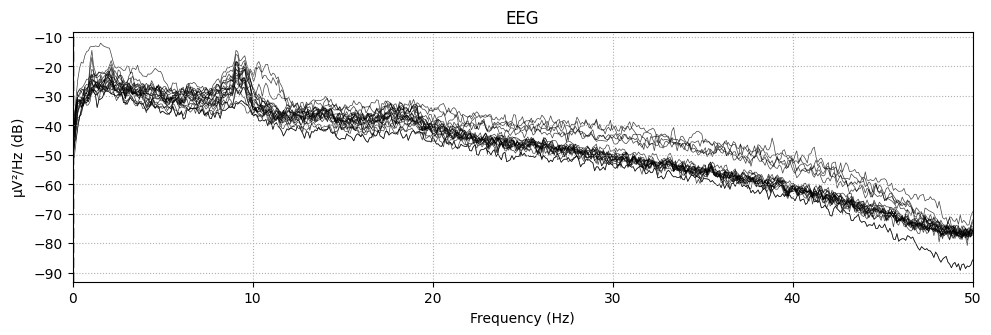

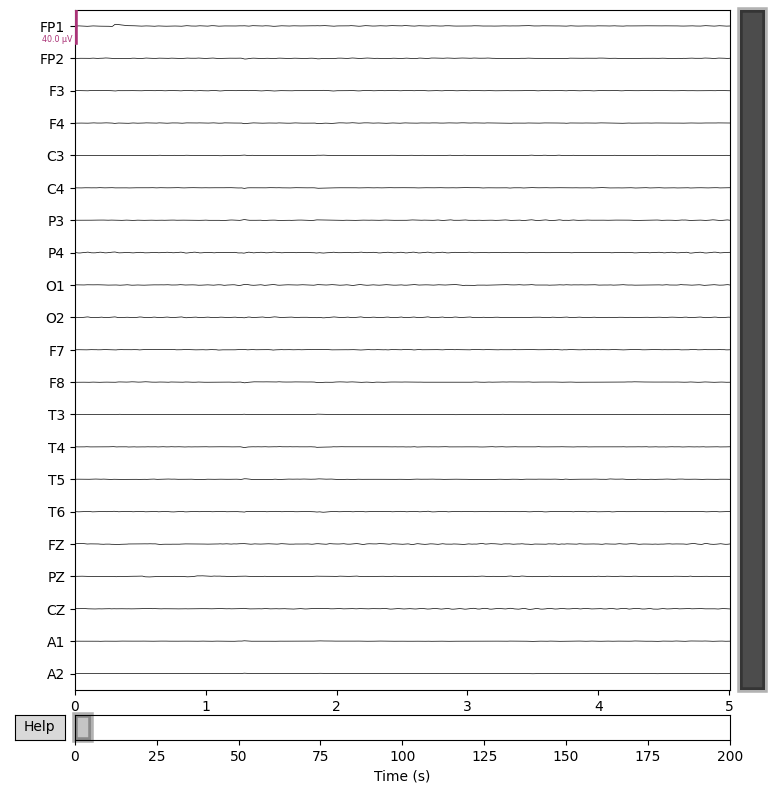

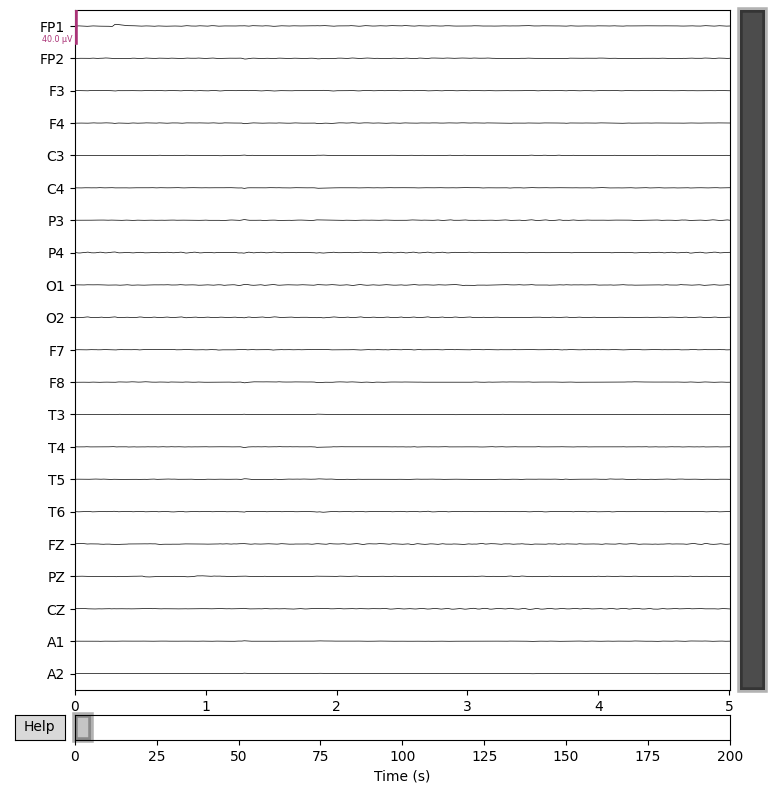

In [54]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=21)

C:\Users\acer\AppData\Local\Temp\ipykernel_21876\2571255294.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(normal_data.age,color='blue')


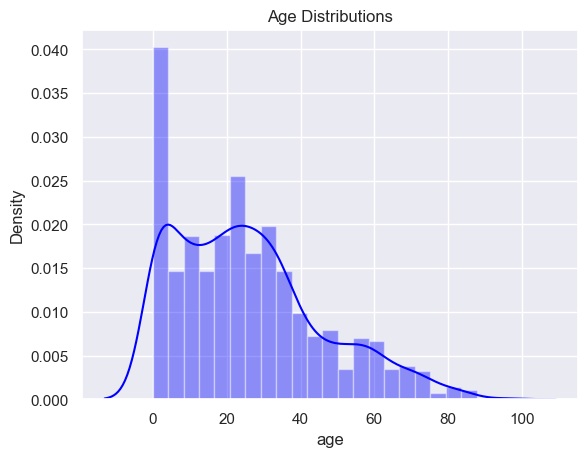

In [170]:
sns.distplot(normal_data.age,color='blue')
plt.title("Age Distributions")
plt.show()

In [149]:
age_group_labels = [
    'Children 0-18', 'Adults 19-25', 'Adults 26-34', 
    'Adults 35-54', 'Adults 55-64', 'Seniors 65+'
]

age_group_populations = [
    len(normal_data[(normal_data['age'] > 0) & (normal_data['age'] <=18)]),
    len(normal_data[(normal_data['age'] > 18) & (normal_data['age'] <=25)]),
    len(normal_data[(normal_data['age'] > 25) & (normal_data['age'] <= 34)]), 
    len(normal_data[(normal_data['age'] > 34) & (normal_data['age'] <=54)]),
    len(normal_data[(normal_data['age'] > 54) & (normal_data['age'] <=64)]),
    len(normal_data[normal_data['age'] > 64])
    
]
# len(main_data[(main_data['age'] > 0) & (main_data['age'] <=18)])

In [192]:
age_group_labels = [
    'Children 0-18', 'Adults 19-25', 'Adults 26-34', 
    'Adults 35-54', 'Adults 55-64', 'Seniors 65+'
]

age_group_populations2 = [
    len(balanced_data33[(balanced_data33['age'] > 0) & (balanced_data33['age'] <=18)]),
    len(balanced_data33[(balanced_data33['age'] > 18) & (balanced_data33['age'] <=25)]),
    len(balanced_data33[(balanced_data33['age'] > 25) & (balanced_data33['age'] <= 34)]), 
    len(balanced_data33[(balanced_data33['age'] > 34) & (balanced_data33['age'] <=54)]),
    len(balanced_data33[(balanced_data33['age'] > 54) & (balanced_data33['age'] <=64)]),
    len(balanced_data33[balanced_data33['age'] > 64])
    
]
# len(main_data[(main_data['age'] > 0) & (main_data['age'] <=18)])

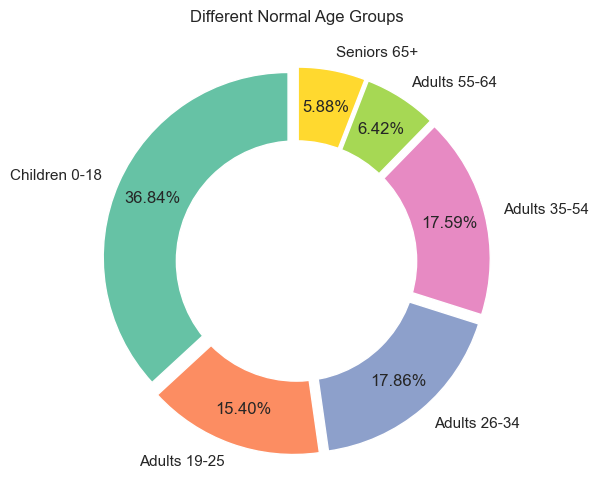

In [193]:
# sns.set(font_scale = 1)
plt.figure(figsize=(6,6))

plt.pie(
    x=age_group_populations2, labels=age_group_labels,
    colors=sns.color_palette('Set2'),
    startangle=90,
    # show percentages
    autopct='%1.2f%%',
    # move the percentage inside the arcs
    pctdistance=0.80,
    # add space between the arcs
    explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
)

### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.title("Different Normal Age Groups")
plt.gcf().gca().add_artist(hole)

plt.show()

In [72]:
normal_data.gender.value_counts()

male             1345
female            650
not specified       1
Name: gender, dtype: int64

In [73]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

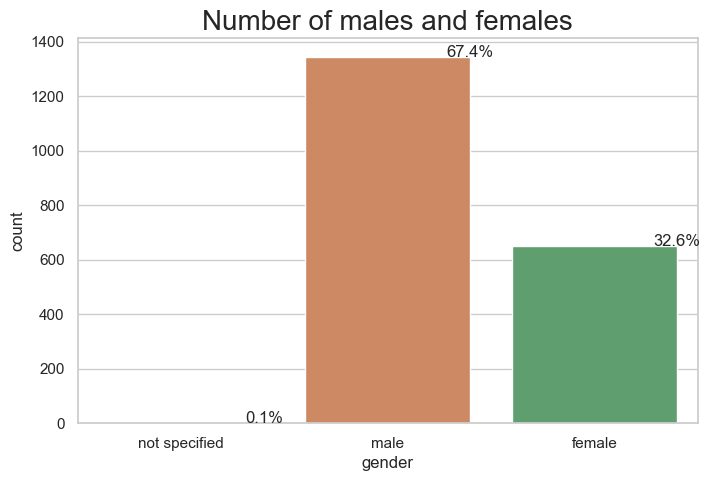

In [78]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(normal_data))
ax = sns.countplot(x="gender", data=normal_data)
plt.title('Number of males and females', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

C:\Users\acer\AppData\Local\Temp\ipykernel_16548\1866456324.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample80.age,color='blue')


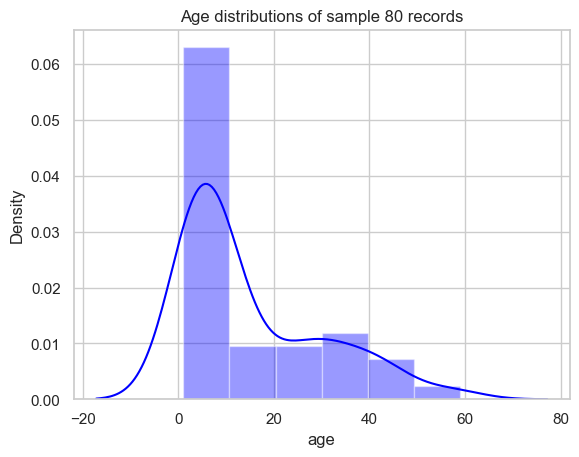

In [85]:
sns.distplot(sample80.age,color='blue')
plt.title("Age distributions of sample 80 records")
plt.show()

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(6,6))

plt.pie(
    x=age_group_populations, labels=age_group_labels,
    colors=sns.color_palette('Set2'),
    startangle=90,
    # show percentages
    autopct='%1.2f%%',
    # move the percentage inside the arcs
    pctdistance=0.80,
    # add space between the arcs
    explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
)

### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.title("Different Normal Age Groups")
plt.gcf().gca().add_artist(hole)
plt.show()

# Preprocessing and feature extraction

In [ ]:
def read_data(file_path):
    data = mne.io.read_raw_edf(file_path,preload=True)
    data.set_eeg_reference()# averaging the reference
    data.filter(l_freq= 0.5, h_freq=45) # It is linear data
    epochs = mne.make_fixed_length_epochs(data, duration=5, overlap=1)#create segement
    array = epochs.get_data() #
    return array

In [18]:
def read_data2(file_path):
    raw= mne.io.read_raw(file_path, preload=True).drop_channels(['A1', 'A2'])
    #split_timestamps = multichannel_sliding_window(raw._data, args.size, args.step)
    raw.filter(1., 40., fir_design='firwin',n_jobs=1)
    raw.resample(sfreq=200)
    raw=custom_crop(raw,tmin = 1 * 60,tmax = 6 * 60)
    split_timestamps = multichannel_sliding_window(raw._data, 500, 250)
    return split_timestamps

In [19]:
def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)
    return raw

In [20]:
def multichannel_sliding_window(X, size, step):
    """
    Generate sliding windows from multichannel 1d data and outputs
    X = np.arange(50).reshape((5, 10))
    print(X)
    [[ 0  1  2  3  4  5  6  7  8  9]
     [10 11 12 13 14 15 16 17 18 19]
     [20 21 22 23 24 25 26 27 28 29]
     [30 31 32 33 34 35 36 37 38 39]
     [40 41 42 43 44 45 46 47 48 49]]
    print(multichannel_sliding_window(X, 4, 2))
    [[[ 0  1  2  3]
      [10 11 12 13]
      [20 21 22 23]
      [30 31 32 33]
      [40 41 42 43]]
     [[ 2  3  4  5]
      [12 13 14 15]
      [22 23 24 25]
      [32 33 34 35]
      [42 43 44 45]]
     [[ 4  5  6  7]
      [14 15 16 17]
      [24 25 26 27]
      [34 35 36 37]
      [44 45 46 47]]]
    """
    shape = (X.shape[0] - X.shape[0] + 1, (X.shape[1] - size + 1) //
             step, X.shape[0], size)
    strides = (X.strides[0], X.strides[1] * step, X.strides[0], X.strides[1])
    return np.lib.stride_tricks.as_strided(X, shape, strides)[0]

In [55]:
normal_data = main_data[main_data["label"]=="normal"]
normal_data


index   recordname   label  age         gender    loc  \
0         0  0000001.edf  normal   22  not specified  train   
1         1  0000003.edf  normal   37           male  train   
2         2  0000005.edf  normal   40           male  train   
3         3  0000006.edf  normal   38         female  train   
4         4  0000007.edf  normal   28           male  train   
...     ...          ...     ...  ...            ...    ...   
2406     84  0002366.edf  normal   22           male   eval   
2407     85  0002375.edf  normal   28           male   eval   
2408     86  0002384.edf  normal   60           male   eval   
2409     87  0002406.edf  normal    1           male   eval   
2410     88  0002407.edf  normal    6           male   eval   

                                              file_path  
0     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
1     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
3     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
4     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
...                                                 ...  
2406  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2407  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2408  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2409  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2410  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  

[1996 rows x 7 columns]

In [25]:
normal_data['gender'].replace({'female':0,'male':1},inplace=True)


C:\Users\acer\AppData\Local\Temp\ipykernel_20172\713772046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data['gender'].replace({'female':0,'male':1},inplace=True)


In [26]:
normal_data = normal_data[normal_data['gender']!='not specified']
normal_data 

index   recordname   label  age gender    loc  \
1         1  0000003.edf  normal   37      1  train   
2         2  0000005.edf  normal   40      1  train   
3         3  0000006.edf  normal   38      0  train   
4         4  0000007.edf  normal   28      1  train   
5         5  0000011.edf  normal   53      1  train   
...     ...          ...     ...  ...    ...    ...   
2406     84  0002366.edf  normal   22      1   eval   
2407     85  0002375.edf  normal   28      1   eval   
2408     86  0002384.edf  normal   60      1   eval   
2409     87  0002406.edf  normal    1      1   eval   
2410     88  0002407.edf  normal    6      1   eval   

                                              file_path  
1     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
3     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
4     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
5     nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
...                                                 ...  
2406  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2407  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2408  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2409  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2410  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  

[1995 rows x 7 columns]

In [27]:
normal_data["file_path"][1]

'nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/normal/train\\0000003.edf'

# Saving the segmented/cropped image file into the file of all trainingset

In [102]:

folder_path_train = './NMTNormaldata/trainset'
folder_path_eval = './NMTNormaldata/testset'
def segment_data(main_data):
      
        for data in main_data['file_path']:
            try:
                segmented_data = read_data2(data)
                file = str(data.split('\\')[1])
                ages = str(main_data.loc[main_data['recordname'] == file,'age'])
                locations = str(main_data.loc[main_data['recordname'] == file,'loc'])
                age_index = int(ages.split(" ")[0]) 
                age = main_data['age'][age_index]  
                location_index = int(locations.split(' ')[0])
                location = main_data['loc'][location_index]
                file_name = file + '_' + str(age)
                if segmented_data.shape==(118,19,500):
                    if location == 'train':
                        np.save(os.path.join(folder_path_train,file_name),segmented_data)
                    else:
                        np.save(os.path.join(folder_path_eval,file_name),segmented_data)
                    
            except:
                pass
        

    

In [103]:
sample_data = segment_data(normal_data)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 193799  =      0.000 ...   968.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 146199  =      0.000 ...   730.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband ed

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140199  =      0.000 ...   700.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000034.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 131799  =      0.000 ...   658.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000050.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143199  =      0.000 ...   715.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000062.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 151799  =      0.000 ...   758.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000075.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 174999  =      0.000 ...   874.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000097.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122999  =      0.000 ...   614.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 191999  =      0.000 ...   959.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 73599  =      0.000 ...   367.995 secs...
Fi

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000127.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109399  =      0.000 ...   546.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000141.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 138799  =      0.000 ...   693.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000155.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 136799  =      0.000 ...   683.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000171.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 111599  =      0.000 ...   557.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109199  =      0.000 ...   545.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000183.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 106999  =      0.000 ...   534.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000193.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 137599  =      0.000 ...   687.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000209.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 157399  =      0.000 ...   786.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000229.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133999  =      0.000 ...   669.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000242.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122199  =      0.000 ...   610.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 136399  =      0.000 ...   681.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000257.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121399  =      0.000 ...   606.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000269.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 259399  =      0.000 ...  1296.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000281.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 151399  =      0.000 ...   756.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000294.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...   719.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000304.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109599  =      0.000 ...   547.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 148799  =      0.000 ...   743.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000319.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 152399  =      0.000 ...   761.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000328.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 176999  =      0.000 ...   884.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000340.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 124799  =      0.000 ...   623.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000351.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168999  =      0.000 ...   844.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000365.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 130799  =      0.000 ...   653.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86799  =      0.000 ...   433.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000377.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 145599  =      0.000 ...   727.995 secs...
Fi

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000389.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 139799  =      0.000 ...   698.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000403.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120199  =      0.000 ...   600.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000414.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135199  =      0.000 ...   675.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000428.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 115399  =      0.000 ...   576.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 116999  =      0.000 ...   584.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000442.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 166199  =      0.000 ...   830.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000453.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 170599  =      0.000 ...   852.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000464.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121799  =      0.000 ...   608.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000474.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120399  =      0.000 ...   601.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000486.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 99599  =      0.000 ...   497.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 103799  =      0.000 ...   518.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000503.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144599  =      0.000 ...   722.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000516.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150399  =      0.000 ...   751.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000527.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122399  =      0.000 ...   611.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000541.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 165799  =      0.000 ...   828.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000555.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 202999  =      0.000 ...  1014.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 165199  =      0.000 ...   825.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000568.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...   719.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000578.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 208599  =      0.000 ...  1042.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000590.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95199  =      0.000 ...   475.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000600.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 117799  =      0.000 ...   588.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000611.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 152199  =      0.000 ...   760.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109599  =      0.000 ...   547.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000625.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 136599  =      0.000 ...   682.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000634.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 100199  =      0.000 ...   500.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000646.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 139399  =      0.000 ...   696.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000657.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 154799  =      0.000 ...   773.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000669.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 57399  =      0.000 ...   286.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96199  =      0.000 ...   480.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000680.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 164599  =      0.000 ...   822.995 secs...
Fi

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000689.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 132599  =      0.000 ...   662.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000699.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 176399  =      0.000 ...   881.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000708.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144599  =      0.000 ...   722.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000720.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 124799  =      0.000 ...   623.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 115199  =      0.000 ...   575.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000730.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 134199  =      0.000 ...   670.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000739.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 100799  =      0.000 ...   503.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000753.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 190199  =      0.000 ...   950.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000762.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147199  =      0.000 ...   735.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000772.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107999  =      0.000 ...   539.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133599  =      0.000 ...   667.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000785.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97399  =      0.000 ...   486.995 secs...
Fi

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000795.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 134999  =      0.000 ...   674.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000807.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 115199  =      0.000 ...   575.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000817.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147399  =      0.000 ...   736.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000830.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155799  =      0.000 ...   778.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 116199  =      0.000 ...   580.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000845.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 134599  =      0.000 ...   672.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000856.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120999  =      0.000 ...   604.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000869.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109999  =      0.000 ...   549.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000881.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 102199  =      0.000 ...   510.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000893.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 100399  =      0.000 ...   501.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 138599  =      0.000 ...   692.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000912.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179599  =      0.000 ...   897.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000923.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 141599  =      0.000 ...   707.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000936.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 83799  =      0.000 ...   418.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000946.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95999  =      0.000 ...   479.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_da

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000957.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 67199  =      0.000 ...   335.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180399  =      0.000 ...   901.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000967.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 108199  =      0.000 ...   540.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000976.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96199  =      0.000 ...   480.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000987.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 152399  =      0.000 ...   761.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000999.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 50599  =      0.000 ...   252.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_da

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 118799  =      0.000 ...   593.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 203999  =      0.000 ...  1019.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120399  =      0.000 ...   601.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001031.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105199  =      0.000 ...   525.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001045.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 108399  =      0.000 ...   541.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001058.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 137599  =      0.000 ...   687.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001070.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105799  =      0.000 ...   528.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144599  =      0.000 ...   722.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001083.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 137799  =      0.000 ...   688.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001093.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 100199  =      0.000 ...   500.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001106.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107999  =      0.000 ...   539.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001116.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...   719.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 101199  =      0.000 ...   505.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120599  =      0.000 ...   602.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001143.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 123199  =      0.000 ...   615.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001157.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 101999  =      0.000 ...   509.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001171.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90599  =      0.000 ...   452.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001182.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144199  =      0.000 ...   720.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001194.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 173799  =      0.000 ...   868.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 146799  =      0.000 ...   733.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001209.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...   719.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001220.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121399  =      0.000 ...   606.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001231.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156199  =      0.000 ...   780.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001245.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156799  =      0.000 ...   783.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001256.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167799  =      0.000 ...   838.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001273.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144199  =      0.000 ...   720.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001283.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156999  =      0.000 ...   784.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001296.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 170399  =      0.000 ...   851.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001309.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133999  =      0.000 ...   669.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001321.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 259999  =      0.000 ...  1299.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 200599  =      0.000 ...  1002.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001335.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 200399  =      0.000 ...  1001.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001344.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189599  =      0.000 ...   947.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001360.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 210599  =      0.000 ...  1052.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001372.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 205799  =      0.000 ...  1028.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001384.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 185399  =      0.000 ...   926.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 210399  =      0.000 ...  1051.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001396.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001410.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144599  =      0.000 ...   722.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001423.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 145399  =      0.000 ...   726.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001437.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120199  =      0.000 ...   600.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001448.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 123999  =      0.000 ...   619.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 159399  =      0.000 ...   796.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001463.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 247599  =      0.000 ...  1237.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001474.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 162799  =      0.000 ...   813.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001485.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 169799  =      0.000 ...   848.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001495.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 123399  =      0.000 ...   616.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001507.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 82999  =      0.000 ...   414.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155999  =      0.000 ...   779.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001521.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181599  =      0.000 ...   907.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001530.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001544.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345399  =      0.000 ...  1726.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001553.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133199  =      0.000 ...   665.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001564.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149599  =      0.000 ...   747.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121199  =      0.000 ...   605.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001581.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 137799  =      0.000 ...   688.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001592.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 125399  =      0.000 ...   626.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001609.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 199199  =      0.000 ...   995.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001620.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147999  =      0.000 ...   739.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001632.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156199  =      0.000 ...   780.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180399  =      0.000 ...   901.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001644.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180999  =      0.000 ...   904.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001656.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 163799  =      0.000 ...   818.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001670.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144199  =      0.000 ...   720.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001680.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147999  =      0.000 ...   739.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001695.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 145799  =      0.000 ...   728.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 110399  =      0.000 ...   551.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001709.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122399  =      0.000 ...   611.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001721.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122399  =      0.000 ...   611.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001733.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 172799  =      0.000 ...   863.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001743.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 132199  =      0.000 ...   660.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001754.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140799  =      0.000 ...   703.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 258399  =      0.000 ...  1291.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001764.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120599  =      0.000 ...   602.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001774.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86399  =      0.000 ...   431.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001785.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 126199  =      0.000 ...   630.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001795.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001806.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11199  =      0.000 ...    55.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 87999  =      0.000 ...   439.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001816.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 94799  =      0.000 ...   473.995 secs...
Fil

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001828.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 115799  =      0.000 ...   578.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001841.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91599  =      0.000 ...   457.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001853.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 131999  =      0.000 ...   659.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001867.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 142199  =      0.000 ...   710.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156399  =      0.000 ...   781.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001877.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 154999  =      0.000 ...   774.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001888.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140199  =      0.000 ...   700.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001901.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 170399  =      0.000 ...   851.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001913.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 174799  =      0.000 ...   873.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001925.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168399  =      0.000 ...   841.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120599  =      0.000 ...   602.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001935.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 32399  =      0.000 ...   161.995 secs...
Fi

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001945.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 192799  =      0.000 ...   963.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001956.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001968.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001979.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 171999  =      0.000 ...   859.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 185999  =      0.000 ...   929.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001989.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001999.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180199  =      0.000 ...   900.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 102399  =      0.000 ...   511.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 172599  =      0.000 ...   862.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002037.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 185199  =      0.000 ...   925.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 171399  =      0.000 ...   856.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002050.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91599  =      0.000 ...   457.995 secs...
Fi

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002067.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180799  =      0.000 ...   903.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002081.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 215799  =      0.000 ...  1078.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002096.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167999  =      0.000 ...   839.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167999  =      0.000 ...   839.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168599  =      0.000 ...   842.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002121.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 164999  =      0.000 ...   824.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 158399  =      0.000 ...   791.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002147.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 170399  =      0.000 ...   851.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002158.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180599  =      0.000 ...   902.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002172.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 214999  =      0.000 ...  1074.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153399  =      0.000 ...   766.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002185.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186199  =      0.000 ...   930.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002195.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 201199  =      0.000 ...  1005.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002212.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167999  =      0.000 ...   839.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002222.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180399  =      0.000 ...   901.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002235.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 151999  =      0.000 ...   759.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168399  =      0.000 ...   841.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002247.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180199  =      0.000 ...   900.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002259.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167999  =      0.000 ...   839.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002275.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 269399  =      0.000 ...  1346.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002285.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 205199  =      0.000 ...  1025.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002297.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 188199  =      0.000 ...   940.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107999  =      0.000 ...   539.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002309.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60799  =      0.000 ...   303.995 secs...
Fi

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002322.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 176399  =      0.000 ...   881.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002336.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 196799  =      0.000 ...   983.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002347.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 237599  =      0.000 ...  1187.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002360.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 175799  =      0.000 ...   878.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 183199  =      0.000 ...   915.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002374.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 164199  =      0.000 ...   820.995 secs...
F

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002388.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186199  =      0.000 ...   930.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 H

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002400.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 196999  =      0.000 ...   984.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002411.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 152799  =      0.000 ...   763.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\abnormal\train\0000085.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 36799  =      0.000 ...   183.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pas

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 59999  =      0.000 ...   299.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\abnormal\train\0000136.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140599  =      0.000 ...   702.995 secs...


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\abnormal\train\0001053.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 148999  =      0.000 ...   744.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper

Reading 0 ... 129399  =      0.000 ...   646.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0000124.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 117599  =      0.000 ...   587.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0000336.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120199  =      0.000 ...   600.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0000596.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 114599  =      0.000 ...   572.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0000914.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 124799  =      0.000 ...   623.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_da

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0001196.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 139599  =      0.000 ...   697.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0001456.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120399  =      0.000 ...   601.995 secs...
Fi

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0001724.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122199  =      0.000 ...   610.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0002047.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 207799  =      0.000 ...  1038.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0002304.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 193799  =      0.000 ...   968.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_da

In [145]:
len(normal_data[normal_data['age'] > 64]),len(normal_data[(normal_data['age'] > 0) & (normal_data['age'] <=18)]),len(normal_data[(normal_data['age'] > 18) & (normal_data['age'] <=25)]),len(normal_data[(normal_data['age'] > 25) & (normal_data['age'] <= 34)]), len(normal_data[(normal_data['age'] > 34) & (normal_data['age'] <=54)]),len(normal_data[(normal_data['age'] > 54) & (normal_data['age'] <=64)])

(110, 689, 288, 334, 329, 120)

In [146]:
normal_data_below18 = normal_data[(normal_data['age'] > 0) & (normal_data['age'] <=18)]
normal_data_above18_below25 = normal_data[(normal_data['age'] > 18) & (normal_data['age'] <=25)]
normal_data_above25_below34 = normal_data[(normal_data['age'] > 25) & (normal_data['age'] <=34)]
normal_data_above34_below54 = normal_data[(normal_data['age'] > 34) & (normal_data['age'] <=54)]
normal_data_above55_below64 = normal_data[(normal_data['age'] > 54) & (normal_data['age'] <=64)]
normal_data_above64 = normal_data[(normal_data['age'] >64)]

In [147]:
normal_data_below18_balance = normal_data_below18[0:110]
normal_data_above18_below25_balance = normal_data_above18_below25[0:110]
normal_data_above25_below34_balance = normal_data_above25_below34[0:110]
normal_data_above34_below54_balance = normal_data_above34_below54[0:110]
normal_data_above55_below64_balance = normal_data_above55_below64[0:110]
normal_data_above64_balance_balance = normal_data[(normal_data['age'] >64)]

balance_data = [normal_data_below18_balance,normal_data_above18_below25_balance,normal_data_above25_below34_balance,
               normal_data_above34_below54_balance,normal_data_above55_below64_balance,normal_data_above64_balance_balance]
balance_data = pd.concat(balance_data)
balance_data

index   recordname   label  age gender    loc  \
11       11  0000022.edf  normal    5      0  train   
12       12  0000023.edf  normal    7      0  train   
19       19  0000032.edf  normal    2      1  train   
21       21  0000034.edf  normal   18      1  train   
25       25  0000039.edf  normal    1      0  train   
...     ...          ...     ...  ...    ...    ...   
1883      6  0000015.edf  normal   95      1  train   
1886      9  0000019.edf  normal   86      1  train   
1909     32  0000113.edf  normal   67      0  train   
2326      4  0000117.edf  normal   70      1   eval   
2382     60  0001684.edf  normal   65      1   eval   

                                              file_path  
11    nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
12    nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
19    nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
21    nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
25    nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
...                                                 ...  
1883  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/ab...  
1886  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/ab...  
1909  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/ab...  
2326  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  
2382  nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/no...  

[660 rows x 7 columns]

# Saving the segmented/cropped image file into the file of Balance data

In [ ]:
folder_path_train = './Balancedata/trainset'
folder_path_eval = './Balancedata/testset'
def segment_data(main_data):
      
        for data in main_data['file_path']:
            try:
                segmented_data = read_data2(data)
                file = str(data.split('\\')[1])
                ages = str(main_data.loc[main_data['recordname'] == file,'age'])
                locations = str(main_data.loc[main_data['recordname'] == file,'loc'])
                age_index = int(ages.split(" ")[0]) 
                age = main_data['age'][age_index]  
                location_index = int(locations.split(' ')[0])
                location = main_data['loc'][location_index]
                file_name = file + '_' + str(age)
                if segmented_data.shape==(118,19,500):
                    if location == 'train':
                        np.save(os.path.join(folder_path_train,file_name),segmented_data)
                    else:
                        np.save(os.path.join(folder_path_eval,file_name),segmented_data)
                    
            except:
                pass
sample_data = segment_data(balance_data)

# Preparing the dataloader for all training dataset including imbalance 

In [ ]:
# trained_df = main_data[main_data['loc']=='train']
trained_df

In [ ]:
class EEGdata(Dataset):
     def __init__(self):
#         csvfile = './nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/Labels.csv'
        self.annotations=normal_data #pd.read_csv('./nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/Labels.csv')
#         self.transform=transform  
    
     def __len__(self):
        return len(self.annotations) # no of images

     def __getitem__(self,index):
        # get the file path
        img_path=self.annotations.file_path.iloc[index]
        #read the image path
        image=np.load(img_path,allow_pickle=True)
        #get the label and convert to tensor
        y_label=torch.tensor(int(self.annotations.gender.iloc[index]))
        #apply transform in batches
        if self.transform:
            image=self.transform(image)
        return image, y_label

csvfile = './nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/Labels.csv'
train_dataset = EEGdata()
train_loader_all = DataLoader(train_dataset, batch_size=15, shuffle=True)                         

In [29]:
file = normal_data.loc[normal_data['recordname'] == '0000003.edf','gender']
file = str(file)
int(file.split(' ')[0])

1

In [ ]:
# normal_data.loc[normal_data['recordname'] == file,'gender']

In [38]:
folder_path_train = './NormalWithGender/trainset'
folder_path_eval = './Balancedata/testset'
def segment_data(main_data):
      
        for data in normal_data['file_path']:
#             print(data.split('\\')[1])
            try:
                segmented_data = read_data2(data)
                file = data.split('\\')[1]
#                 print(file)
#                 print(segmented_data.shape)
                gender = str(normal_data.loc[normal_data['recordname'] == file,'gender'])
               
                index_gender = int(gender.split(' ')[0])
                print(index_gender)
                gender = normal_data['gender'][index_gender]
                print(gender)
                file_name = file + '_' + str(gender)
#                 print(file_name)
                if segmented_data.shape==(118,19,500):
                    print(segmented_data.shape)
                    np.save(os.path.join(folder_path_train,file_name),segmented_data)
                    
                        
                    
            except:
                
                pass
            


In [39]:
sample_data = segment_data(normal_data)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 193799  =      0.000 ...   968.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_da

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

10
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 146199  =      0.000 ...   730.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase,

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

19
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000033.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140199  =      0.000 ...   700.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133799  =      0.000 ...   668.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

29
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000050.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143199  =      0.000 ...

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

38
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000060.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147599  =      0.000 ...   737.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation

- Filter length: 661 samples (3.305 sec)

47
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000073.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 184799  =      0.000 ...   923.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

48
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semes

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

57
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000095.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 126799  =      0.000 ...   633.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
------------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

66
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000107.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133399  =      0.000 ...   666.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 159999  =      0.000 ...   799.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

76
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000125.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 70799  =      0.000 ... 

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

85
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000138.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147799  =      0.000 ...   738.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation

- Filter length: 661 samples (3.305 sec)

94
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000152.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168199  =      0.000 ...   840.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

95
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semes

Reading 0 ... 148599  =      0.000 ...   742.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

104
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000169.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144199  =      0.000 ...   720.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

113
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000179.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 125799  =      0.000 ...   628.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

122
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000190.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107599  =      0.000 ...   537.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

123
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 94399  =      0.000 ...   471.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

132
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000202.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97199  =      0.000 ...   485.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass f

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

141
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000226.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 151599  =      0.000 ...   757.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

150
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000235.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 141599  =      0.000 ...   707.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

151
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 127199  =      0.000 ...   635.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

160
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000250.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 211399  =      0.000 ...  1056.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

169
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000263.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121799  =      0.000 ...   608.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti


178
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000275.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...   719.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

179
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

188
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000289.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144999  =      0.000 ...   724.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-----------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

197
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000299.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186599  =      0.000 ...   932.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119399  =      0.000 ...   596.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

207
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000310.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95799  =      0.000 ...

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

216
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000323.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167599  =      0.000 ...   837.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

225
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000333.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120799  =      0.000 ...   603.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

226
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

235
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000345.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133199  =      0.000 ...   665.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

244
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000356.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105999  =      0.000 ...   529.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

253
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000370.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381199  =      0.000 ...  1905.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

254
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 143999  =      0.000 ...   719.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

263
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000380.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 159399  =      0.000 ...   796.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

272
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000392.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189199  =      0.000 ...   945.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

281
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000405.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 162399  =      0.000 ...   811.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

282
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 131999  =      0.000 ...   659.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

291
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000417.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 113199  =      0.000 ...   565.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

300
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000431.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 141999  =      0.000 ...   709.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

309
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000443.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 125399  =      0.000 ...   626.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

310
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 137599  =      0.000 ...   687.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

319
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000456.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 115199  =      0.000 ...   575.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

328
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000465.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135599  =      0.000 ...   677.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

337
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000475.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135399  =      0.000 ...   676.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

338
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 99599  =      0.000 ...   497.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

347
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000487.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 112999  =      0.000 ...   564.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass 

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

356
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000503.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144599  =      0.000 ...   722.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

365
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000516.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150399  =      0.000 ...   751.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

366
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 102999  =      0.000 ...   514.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

375
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000527.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122399  =      0.000 ...   611.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

384
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000541.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 165799  =      0.000 ...   828.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109199  =      0.000 ...   545.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

394
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000555.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 202999  =      0.000 ..

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

403
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000567.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 165199  =      0.000 ...   825.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

412
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000577.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322599  =      0.000 ...  1612.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

413
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 139399  =      0.000 ...   696.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

422
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000589.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135399  =      0.000 ...   676.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

431
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000599.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 137399  =      0.000 ...   686.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 123799  =      0.000 ...   618.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

441
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000610.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 152199  =      0.000 ..

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

450
1
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000622.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 101599  =      0.000 ...   507.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

- Filter length: 661 samples (3.305 sec)

459
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000632.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 164399  =      0.000 ...   821.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

460
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 107999  =      0.000 ...   539.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

469
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000642.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 112999  =      0.000 ...   564.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000655.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135199  =      0.000 ...   675.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz


487
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000664.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135399  =      0.000 ...   676.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

488
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000677.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 113599  =      0.000 ...   567.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing 

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

506
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000686.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147599  =      0.000 ...   737.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140399  =      0.000 ...   701.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

516
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000696.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144399  =      0.000 ..

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

525
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000705.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156199  =      0.000 ...   780.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

534
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000716.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153799  =      0.000 ...   768.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

535
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 177399  =      0.000 ...   886.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

544
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000726.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 134199  =      0.000 ...   670.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

553
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000735.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60999  =      0.000 ...   304.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transitio


562
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000747.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 87999  =      0.000 ...   439.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

563
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_d

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

572
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000758.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144399  =      0.000 ...   721.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-----------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

581
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000767.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 113799  =      0.000 ...   568.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107999  =      0.000 ...   539.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

591
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000777.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 114199  =      0.000 ..

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

600
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000790.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 128599  =      0.000 ...   642.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

609
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000800.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 134999  =      0.000 ...   674.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

610
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 62799  =      0.000 ...   313.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

619
1
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000811.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 100799  =      0.000 ...   503.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 -

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

628
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000821.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 69199  =      0.000 ...   345.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transitio


637
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000834.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156999  =      0.000 ...   784.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

638
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

647
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000849.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 141199  =      0.000 ...   705.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-----------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

656
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000859.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 141599  =      0.000 ...   707.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 137199  =      0.000 ...   685.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

666
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000874.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 138999  =      0.000 ..

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

675
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000885.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 151799  =      0.000 ...   758.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

684
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000897.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   749.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

685
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 167999  =      0.000 ...   839.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

694
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000915.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121799  =      0.000 ...   608.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

703
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000925.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135599  =      0.000 ...   677.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

712
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000937.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122199  =      0.000 ...   610.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

713
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 181199  =      0.000 ...   905.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

722
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000949.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 199599  =      0.000 ...   997.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

731
1
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000958.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15799  =      0.000 ...    78.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.


740
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000967.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 108199  =      0.000 ...   540.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

741
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

750
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000977.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95999  =      0.000 ...   479.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
------------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

759
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0000987.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 152399  =      0.000 ...   761.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 50599  =      0.000 ...   252.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

769
1
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 111599  =      0.000 ...   557.995 secs

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

778
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 118799  =      0.000 ...   593.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

787
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 203999  =      0.000 ...  1019.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

788
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 123399  =      0.000 ...   616.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

797
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001031.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105199  =      0.000 ...   525.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

806
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001044.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 99399  =      0.000 ...   496.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transitio

- Filter length: 661 samples (3.305 sec)

815
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001055.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179199  =      0.000 ...   895.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

816
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 121199  =      0.000 ...   605.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

825
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001069.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 111399  =      0.000 ...   556.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

834
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001080.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 131999  =      0.000 ...   659.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

843
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001091.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 112799  =      0.000 ...   563.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

844
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 96199  =      0.000 ...   480.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

853
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001104.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120399  =      0.000 ...   601.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass 

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

862
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001113.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 110599  =      0.000 ...   552.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti


871
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001129.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120199  =      0.000 ...   600.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

872
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

881
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001139.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 131999  =      0.000 ...   659.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-----------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

890
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001151.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 131999  =      0.000 ...   659.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 126799  =      0.000 ...   633.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

900
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001167.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122599  =      0.000 ..

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

909
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001178.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 246399  =      0.000 ...  1231.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

918
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001190.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167999  =      0.000 ...   839.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

919
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 76199  =      0.000 ...   380.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

928
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001203.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120199  =      0.000 ...   600.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass 

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

937
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001215.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 131999  =      0.000 ...   659.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

946
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001226.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109999  =      0.000 ...   549.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

947
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 167999  =      0.000 ...   839.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

956
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001237.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

965
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001251.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...   719.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

974
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001262.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

975
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Sem

Reading 0 ... 156399  =      0.000 ...   781.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

984
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001277.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155999  =      0.000 ...   779.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

993
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001287.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 132199  =      0.000 ...   660.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

1002
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001299.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 224599  =      0.000 ...  1122.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1003
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Reading 0 ... 204399  =      0.000 ...  1021.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1012
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001315.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 141399  =      0.000 ...   706.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pas

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1021
0
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001324.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 162199  =      0.000 ...   810.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 

- Filter length: 661 samples (3.305 sec)

1030
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001337.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 219199  =      0.000 ...  1095.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1031
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Reading 0 ... 23399  =      0.000 ...   116.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1040
1
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001349.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 177599  =      0.000 ...   887.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1049
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001363.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167599  =      0.000 ...   837.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transit

- Filter length: 661 samples (3.305 sec)

1058
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001374.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180199  =      0.000 ...   900.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1059
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Reading 0 ... 61999  =      0.000 ...   309.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1068
1
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001387.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 182799  =      0.000 ...   913.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1077
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001397.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...   219.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

- Filter length: 661 samples (3.305 sec)

1086
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001411.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 114399  =      0.000 ...   571.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1087
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 145399  =      0.000 ...   726.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1096
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001424.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 196599  =      0.000 ...   982.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1105
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001438.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179799  =      0.000 ...   898.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1114
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001448.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 123999  =      0.000 ...   619.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1115
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 159399  =      0.000 ...   796.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1124
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001463.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 247599  =      0.000 ...  1237.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1133
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001474.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 162799  =      0.000 ...   813.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1142
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001484.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 162999  =      0.000 ...   814.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1143
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Reading 0 ... 188999  =      0.000 ...   944.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1152
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001495.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 123399  =      0.000 ...   616.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pas

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1161
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001506.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...   719.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transit

- Filter length: 661 samples (3.305 sec)

1170
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001518.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 134399  =      0.000 ...   671.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1171
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 97799  =      0.000 ...   488.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1180
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001529.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109599  =      0.000 ...   547.995 secs...
Filtering raw data in 1 contiguo

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1189
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001542.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1198
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001551.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153399  =      0.000 ...   766.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1199
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 169599  =      0.000 ...   847.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1208
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001562.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 138999  =      0.000 ...   694.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1217
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001578.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 134399  =      0.000 ...   671.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1226
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001589.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 85599  =      0.000 ...   427.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1227
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Se

Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1236
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001603.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 101199  =      0.000 ...   505.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pas

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1245
0
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001617.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120599  =      0.000 ...   602.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 


1254
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001628.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 162399  =      0.000 ...   811.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1255
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_ee

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1264
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001638.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 26999  =      0.000 ...   134.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-----------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1273
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001649.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147999  =      0.000 ...   739.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband ed

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180199  =      0.000 ...   900.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1283
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001665.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144799  =      0.000 .

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1292
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001676.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120399  =      0.000 ...   601.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming w

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1301
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001688.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 124399  =      0.000 ...   621.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter leng

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 256599  =      0.000 ...  1282.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1311
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001701.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 194399  =      0.000 .

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1320
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001716.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 108199  =      0.000 ...   540.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming w

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1329
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001727.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 123199  =      0.000 ...   615.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

133

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133199  =      0.000 ...   665.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1339
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001738.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120599  =      0.000 .

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1348
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001748.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...   719.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming w

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1357
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001757.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 202599  =      0.000 ...  1012.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter leng

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 126399  =      0.000 ...   631.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1367
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001767.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 146399  =      0.000 .

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1376
0
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001778.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 102399  =      0.000 ...   511.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1385
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001787.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 101799  =      0.000 ...   508.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter leng

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 158799  =      0.000 ...   793.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1395
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001799.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122399  =      0.000 .

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1404
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001808.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 176799  =      0.000 ...   883.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1413
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001817.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1414
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1423
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001830.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107999  =      0.000 ...   539.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1432
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001844.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 123199  =      0.000 ...   615.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband ed

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 144799  =      0.000 ...   723.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1442
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001858.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 922  =      0.000 ... 

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1451
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001868.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122399  =      0.000 ...   611.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1460
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001877.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 154999  =      0.000 ...   774.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1461
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 140199  =      0.000 ...   700.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1470
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001889.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 113199  =      0.000 ...   565.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1479
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001901.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 170399  =      0.000 ...   851.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1488
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001913.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 174799  =      0.000 ...   873.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1489
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 121199  =      0.000 ...   605.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1498
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001925.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168399  =      0.000 ...   841.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1507
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001934.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 120599  =      0.000 ...   602.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1516
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001944.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1517
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Reading 0 ... 169199  =      0.000 ...   845.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1526
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001955.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 152799  =      0.000 ...   763.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pas

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1535
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001965.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transit

- Filter length: 661 samples (3.305 sec)

1544
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001977.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189199  =      0.000 ...   945.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1545
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1554
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001987.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 191999  =      0.000 ...   959.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pas

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1563
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0001996.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transit

- Filter length: 661 samples (3.305 sec)

1572
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180399  =      0.000 ...   901.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1573
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1582
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 183199  =      0.000 ...   915.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1591
1
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002034.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 246199  =      0.000 ...  1230.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pass

- Filter length: 661 samples (3.305 sec)

1600
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002043.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1601
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 161999  =      0.000 ...   809.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1610
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002060.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 179999  =      0.000 ...   899.995 secs...
Filtering raw data in 1 contigu

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1619
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002073.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 190799  =      0.000 ...   953.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transit

- Filter length: 661 samples (3.305 sec)

1628
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002089.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 171399  =      0.000 ...   856.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1629
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 197999  =      0.000 ...   989.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1638
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002104.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168399  =      0.000 ...   841.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1647
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002116.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180599  =      0.000 ...   902.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1656
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002127.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168199  =      0.000 ...   840.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1657
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 181199  =      0.000 ...   905.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1666
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002140.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 167999  =      0.000 ...   839.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1675
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002152.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 169999  =      0.000 ...   849.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1684
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002163.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 192799  =      0.000 ...   963.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1685
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 156599  =      0.000 ...   782.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1694
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002178.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 248199  =      0.000 ...  1240.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1703
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002189.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 204399  =      0.000 ...  1021.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1712
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002199.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 177199  =      0.000 ...   885.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1713
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 167199  =      0.000 ...   835.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1722
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002215.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 162599  =      0.000 ...   812.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1731
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002227.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 199599  =      0.000 ...   997.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1740
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002238.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180199  =      0.000 ...   900.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1741
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Creating raw.info structure...
Reading 0 ... 168399  =      0.000 ...   841.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1750
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002250.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 182799  =      0.000 ...   913.995 secs...
Filtering raw data in 1 contigu

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1759
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002263.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 130599  =      0.000 ...   652.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1768
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002277.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186199  =      0.000 ...   930.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1769
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second S

Reading 0 ... 181599  =      0.000 ...   907.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1778
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002288.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 252599  =      0.000 ...  1262.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pas

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1787
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002298.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155199  =      0.000 ...   775.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transit


1796
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002309.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60799  =      0.000 ...   303.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1797
0
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_sc

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1806
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002323.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180199  =      0.000 ...   900.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
----------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1815
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002336.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 196799  =      0.000 ...   983.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband ed

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 237599  =      0.000 ...  1187.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1825
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002348.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 253599  =      0.000 .

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1834
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002360.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 175799  =      0.000 ...   878.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming w

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1843
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002372.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 183199  =      0.000 ...   915.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter leng

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168599  =      0.000 ...   842.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1853
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002388.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186199  =      0.000 .

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1862
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002399.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155999  =      0.000 ...   779.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

- Filter length: 661 samples (3.305 sec)

1871
0
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\train\0002410.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 133399  =      0.000 ...   666.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1872
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mi

Creating raw.info structure...
Reading 0 ... 144999  =      0.000 ...   724.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1893
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\abnormal\train\0000068.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 126599  =      0.000 ...   632.995 secs...
Filtering raw data in 1 conti

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

1911
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\abnormal\train\0000130.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 64999  =      0.000 ...   324.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuat

- Filter length: 661 samples (3.305 sec)

1933
0
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\abnormal\train\0000840.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 163999  =      0.000 ...   819.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2006
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second

Creating raw.info structure...
Reading 0 ... 179799  =      0.000 ...   898.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2324
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0000077.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 182199  =      0.000 ...   910.995 secs...
Filtering raw data in 1 contiguo

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2333
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0000274.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 233999  =      0.000 ...  1169.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0000544.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150999  =      0.000 ...   754.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2343
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2352
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0000844.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 142199  =      0.000 ...   710.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-----------

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2361
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0001114.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 119999  =      0.000 ...   599.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edg

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 58599  =      0.000 ...   292.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2371
1
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0001416.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 187199  =      0.000 ...   935.995 secs

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2380
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0001594.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 145599  =      0.000 ...   727.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

- Filter length: 661 samples (3.305 sec)

2389
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0001896.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 222199  =      0.000 ...  1110.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2390
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Se

Reading 0 ... 89399  =      0.000 ...   446.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2399
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0002196.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 216199  =      0.000 ...  1080.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass 

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

2408
1
(118, 19, 500)
Extracting EDF parameters from D:\Oslo\OsloMet\Second Semester\Data Mining at Scale\nmt_scalp_eeg_dataset\nmt_scalp_eeg_dataset\normal\eval\0002406.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156599  =      0.000 ...   782.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

In [ ]:
file = './nmt_scalp_eeg_dataset/nmt_scalp_eeg_dataset/Labels.csv'
pd.read_csv(file)

In [ ]:
trained_df

# Dataloader for all dataset for creating pre-trained model

In [25]:
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
class NumpyDataset(Dataset):
    def __init__(self,folder_path):
        self.file_paths = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path) if file_name.endswith(".npy")]
#         self.transform = transforms.Compose([transforms.ToTensor()])
          
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if os.path.isfile(self.file_paths[idx]):
            #print(self.file_paths[idx])
            data_array = np.load(self.file_paths[idx],allow_pickle=True)
            data_tensor = torch.from_numpy(data_array).float()
            
            
          
            age_label = self.file_paths[idx].split('_')[1]
            age_label = float(age_label.split('.')[0])
            gender = self.file_paths[idx]
#             if age_label.isdigit() == False:
#                 age_label = int(age_label.split(".")[0])
#                 age_label = np.array(age_label) 
            age_label = torch.tensor(age_label, dtype = torch.float32)
            return data_tensor, age_label
        else:
            print(f"Warning: {self.file_paths[idx]} is not a file.")   
            return None         

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create datasets and data loaders for training and testing

folder_path_train_set = './NMTNormaldata/trainset'

train_dataset = NumpyDataset(folder_path_train_set)
train_loader_all = DataLoader(train_dataset, batch_size=15, shuffle=True)

folder_path_test_set = './NMTNormaldata/testset'
test_dataset = NumpyDataset(folder_path_test_set)
test_loader_all = DataLoader(test_dataset, batch_size=15)


# Dataloader for 80 sample

In [14]:
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
class NumpyDataset(Dataset):
    def __init__(self,folder_path):
        self.file_paths = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path) if file_name.endswith(".npy")]
#         self.transform = transforms.Compose([transforms.ToTensor()])
          
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if os.path.isfile(self.file_paths[idx]):
            #print(self.file_paths[idx])
            data_array = np.load(self.file_paths[idx],allow_pickle=True)
            data_tensor = torch.from_numpy(data_array).float()
            
            
          
            age_label = self.file_paths[idx].split('_')[1]
            age_label = float(age_label.split('.')[0])
            gender = self.file_paths[idx]
#             if age_label.isdigit() == False:
#                 age_label = int(age_label.split(".")[0])
#                 age_label = np.array(age_label) 
            age_label = torch.tensor(age_label, dtype = torch.float32)
            return data_tensor, age_label
        else:
            print(f"Warning: {self.file_paths[idx]} is not a file.")   
            return None         

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create datasets and data loaders for training and testing

folder_path_train_set = './NMTNormaldata_80/trainset'

train_dataset = NumpyDataset(folder_path_train_set)
train_loader_80 = DataLoader(train_dataset, batch_size=15, shuffle=True)

folder_path_test_set = './NMTNormaldata_80/testset'
test_dataset = NumpyDataset(folder_path_test_set)
test_loader_80 = DataLoader(test_dataset, batch_size=15)


# Model1: CNN with LSTM(creating pre-trained model)

In [119]:
class EEGCNNLSTM(nn.Module):
    def __init__(self):
        super(EEGCNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(118, 64, kernel_size=2, stride=1, padding=1)
        self.nom1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=2, stride=1, padding=1)  
        self.nom2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=1)  
        self.nom3 = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=16 * 3 * 63, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 1) 
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.nom1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.nom2(out)       
        out = self.relu2(out)
        out = self.maxpool2(out)
#         print(out)
        out = self.conv3(out)
        out = self.nom3(out)       
        out = self.relu3(out)
        out = self.maxpool3(out)
#         print(out.shape) 
        out = out.view(out.size(0), -1)  # flatten tensor
        out = out.unsqueeze(0)  # add batch dimension for LSTM
#         print(out)
        out, _ = self.lstm(out)
#         print(out.shape)
        out = out[:, -1, :]  # get the last LSTM output
        out = self.fc(out)
        return out

In [ ]:
print(cnn)

# Balancing the data and applying L1Loss and Optimizer

In [114]:
y = []
for a,b in train_loader_all:
    y.append(b)

In [123]:
#balancing the weight
# class_weights = torch.tensor(class_weight.compute_sample_weight('balanced', y))
cnnmodellstm = EEGCNNLSTM()
criterioncnnlstm = nn.L1Loss()# what is the differene between crossentropy , binary crossentropy and nn.L1loss
optimizercnnlstm = optim.Adam(cnnmodellstm.parameters(),lr=0.01)

In [133]:
# print(cnnmodellstm.parameters)

In [ ]:
def train_model(model):
    training_loss2 = []
    train_hist = []
    val_hist = []
    for epoch in range(20):
        running_loss = 0.0
        running_acc = 0.0
        for i, (inputs, labels) in enumerate(train_loader_all):
            optimizercnnlstm.zero_grad()
            outputs = cnnmodellstm(inputs) 
            labels = labels.view(-1, 1)
            loss = criterioncnnlstm(outputs, labels)
            loss.backward()
            optimizercnnlstm.step()
            running_loss += loss.item()           
            predicted = torch.round(outputs)
            correct = (predicted == labels).sum().item() 
            
            running_acc += correct   
            
        with torch.no_grad():
            test_loss = 0.0
            for inputs, labels in test_loader_all:
                outputs = cnnmodellstm(inputs)
                
                labels = labels.view(-1,1)
#                     model2_loss_records1.append({'real':labels.flatten().numpy(), 'predict':outputs.flatten().numpy()})
                test_loss += criterioncnnlstm(outputs, labels).item()
                
#                
        train_hist.append(running_loss / len(train_loader_all))
        val_hist.append((test_loss/len(test_loader_all)))       

        epoch_acc = running_acc / (len(train_loader_all))
        
        print('Epoch %d Train_loss %.3f  Val_loss: %.3f Epoch_acc %.3f' % (epoch+1, running_loss/len(train_loader_all), (test_loss/len(test_loader_all)),epoch_acc)) # print train loss ,validation loss for each epoch of batch size.
        
    

            
    return model, train_hist, val_hist

In [79]:
modelcnnlstm1, train_histcnnlstm1, val_histcnnlstm1 = train_model(cnnmodellstm)

Epoch 1 Train_loss 16.080  Val_loss: 12.703 Epoch_acc 1.007
Epoch 2 Train_loss 16.014  Val_loss: 12.894 Epoch_acc 0.646
Epoch 3 Train_loss 16.151  Val_loss: 13.240 Epoch_acc 0.627
Epoch 4 Train_loss 16.076  Val_loss: 12.731 Epoch_acc 0.722
Epoch 5 Train_loss 16.055  Val_loss: 12.813 Epoch_acc 0.874
Epoch 6 Train_loss 16.028  Val_loss: 13.045 Epoch_acc 0.741
Epoch 7 Train_loss 16.059  Val_loss: 12.675 Epoch_acc 0.570
Epoch 8 Train_loss 16.023  Val_loss: 12.675 Epoch_acc 0.817
Epoch 9 Train_loss 16.092  Val_loss: 12.692 Epoch_acc 0.684
Epoch 10 Train_loss 16.036  Val_loss: 12.729 Epoch_acc 0.665
Epoch 11 Train_loss 15.997  Val_loss: 12.677 Epoch_acc 0.703
Epoch 12 Train_loss 15.993  Val_loss: 12.899 Epoch_acc 0.684
Epoch 13 Train_loss 16.108  Val_loss: 12.722 Epoch_acc 0.722
Epoch 14 Train_loss 16.060  Val_loss: 12.842 Epoch_acc 0.950
Epoch 15 Train_loss 16.147  Val_loss: 12.681 Epoch_acc 0.475
Epoch 16 Train_loss 16.075  Val_loss: 12.721 Epoch_acc 0.779
Epoch 17 Train_loss 16.069  Val_l

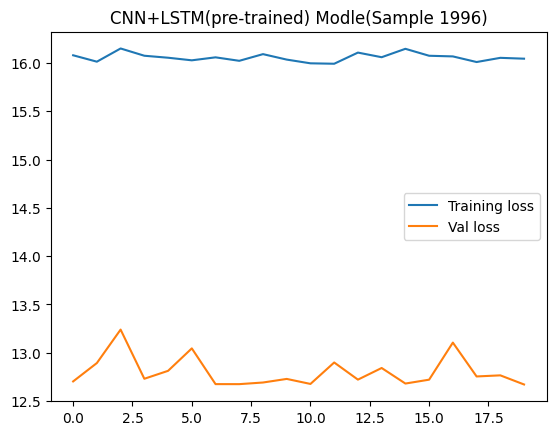

In [85]:
plt.plot(train_histcnnlstm1, label="Training loss")
plt.plot(val_histcnnlstm1, label="Val loss")
plt.title("CNN+LSTM(pre-trained) Modle(Sample 1996)")
plt.legend()

# Saving the model

In [124]:
PATH = './Saved Model/pretrainedcnnlstmmodel'
torch.save(cnnmodellstm.state_dict(), PATH)

## Model2: CNN with LSTMs(Pretrained) + New CNN Model

In [128]:
class EEGNetCNN(nn.Module):
    def __init__(self):
        super(EEGNetCNN, self).__init__()
        self.conv1 = nn.Conv2d(118, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)        
        self.fc = nn.Linear(16*2*62,1)

        #loading the saved model
        pretrained_dict = torch.load(PATH)
        model_dict = self.state_dict()
        
        # 1. filter out unnecessary keys
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        
        # 2. overwrite entries in the existing state dict
        model_dict.update(pretrained_dict)
        
        # 3. load the new state dict
        self.load_state_dict(model_dict)
        
        for param in self.parameters():
            param.requires_grad = False
        
        # Unfreeze the parameters of the last fully connected layer
        for param in self.fc3.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         out = self.fc(out) 
        out = self.fc1(out)  # first dense layer
        out = self.fc2(out)  # second dense layer
        out = self.fc3(out)  # output layer

        return out


In [132]:
print(newcnnmodel.parameter)

In [131]:
newcnnmodel = EEGNetCNN()
criterioncnn = nn.L1Loss()# what is the differene between crossentropy , binary crossentropy and nn.L1loss
optimizercnn = optim.Adam(newcnnmodel.parameters(),lr=0.01)

In [66]:
def train_model(model):
    training_loss2 = []
    train_hist = []
    val_hist = []
    for epoch in range(20):
        running_loss = 0.0
        running_acc = 0.0
        for i, (inputs, labels) in enumerate(train_loader_80):
            optimizercnn.zero_grad()
            outputs = model(inputs) 
            labels = labels.view(-1, 1)
            loss = criterioncnn(outputs, labels)
            loss.backward()
            optimizercnn.step()
            running_loss += loss.item()       
            
            predicted = torch.round(outputs)
            correct = (predicted == labels).sum().item() 
   
            running_acc += correct            
#             print('Batch->'+str(i),'Loss->'+str(loss.item()))         

        with torch.no_grad():
            test_loss = 0.0
            for inputs, labels in test_loader_80:
                outputs = cnnmodel(inputs)

                labels = labels.view(-1,1)
#                     model2_loss_records1.append({'real':labels.flatten().numpy(), 'predict':outputs.flatten().numpy()})
                test_loss += criterioncnn(outputs, labels).item()
                
#                 print("Val Loss->:" + str((test_loss/len(test_loader))))
        train_hist.append(running_loss / len(train_loader_80))
        val_hist.append((test_loss/len(test_loader_80)))
        epoch_acc = running_acc / (len(train_loader_all))
        print('Epoch %d Train_loss %.3f  Val_loss: %.3f Epoch_acc %.3f' % (epoch+1, running_loss/len(train_loader_all), (test_loss/len(test_loader_all)),epoch_acc)) # print train loss ,validation loss for each epoch of batch size.
        
            
    return model, train_hist, val_hist

In [67]:
model1, train_hist1, val_hist1 = train_model(newcnnmodel)

Epoch 1 Train_loss 12.259  Val_loss: 9.232 Epoch_acc 0.554
Epoch 2 Train_loss 12.126  Val_loss: 9.676 Epoch_acc 0.529
Epoch 3 Train_loss 11.660  Val_loss: 9.881 Epoch_acc 0.727
Epoch 4 Train_loss 11.409  Val_loss: 9.002 Epoch_acc 0.760
Epoch 5 Train_loss 11.552  Val_loss: 9.452 Epoch_acc 0.752
Epoch 6 Train_loss 11.638  Val_loss: 9.849 Epoch_acc 0.612
Epoch 7 Train_loss 10.938  Val_loss: 8.736 Epoch_acc 0.777
Epoch 8 Train_loss 10.723  Val_loss: 9.286 Epoch_acc 0.810
Epoch 9 Train_loss 10.443  Val_loss: 9.858 Epoch_acc 0.694
Epoch 10 Train_loss 9.990  Val_loss: 9.073 Epoch_acc 0.826
Epoch 11 Train_loss 9.957  Val_loss: 8.847 Epoch_acc 0.669
Epoch 12 Train_loss 9.730  Val_loss: 9.039 Epoch_acc 0.711
Epoch 13 Train_loss 9.154  Val_loss: 8.862 Epoch_acc 0.843
Epoch 14 Train_loss 8.955  Val_loss: 9.863 Epoch_acc 0.851
Epoch 15 Train_loss 9.395  Val_loss: 9.450 Epoch_acc 0.810
Epoch 16 Train_loss 10.192  Val_loss: 8.226 Epoch_acc 0.612
Epoch 17 Train_loss 9.862  Val_loss: 9.344 Epoch_acc 0.

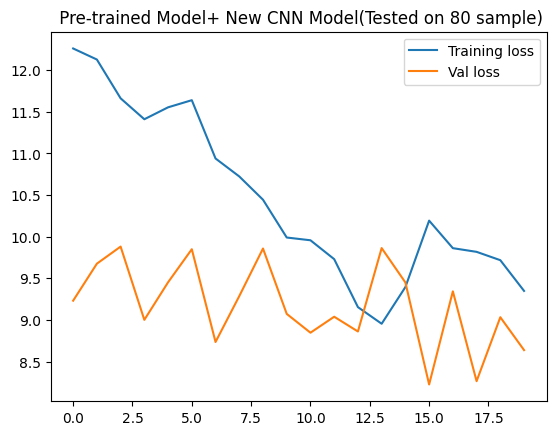

In [84]:
plt.plot(train_hist1, label="Training loss")
plt.plot(val_hist1, label="Val loss")
plt.title(" Pre-trained Model+ New CNN Model(Tested on 80 sample)")
plt.legend()

# Pre-trained model ( CNN + LSTM) Model) for 80 sample

In [23]:
class EEGCNNLSTM(nn.Module):
    def __init__(self):
        super(EEGCNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(118, 64, kernel_size=2, stride=1, padding=1)
        self.nom1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=2, stride=1, padding=1)  
        self.nom2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=1)  
        self.nom3 = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=16 * 3 * 63, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 1) 
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.nom1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.nom2(out)       
        out = self.relu2(out)
        out = self.maxpool2(out)
#         print(out)
        out = self.conv3(out)
        out = self.nom3(out)       
        out = self.relu3(out)
        out = self.maxpool3(out)
#         print(out.shape) 
        out = out.view(out.size(0), -1)  # flatten tensor
        out = out.unsqueeze(0)  # add batch dimension for LSTM
#         print(out)
        out, _ = self.lstm(out)
#         print(out.shape)
        out = out[:, -1, :]  # get the last LSTM output
        out = self.fc(out)
        return out

In [29]:
cnnmodellstm_80sample = EEGCNNLSTM()
criterioncnnlstm_80 = nn.L1Loss()# what is the differene between crossentropy , binary crossentropy and nn.L1loss
optimizercnnlstm_80 = optim.Adam(cnnmodellstm_80sample.parameters(),lr=0.01)

In [32]:
def train_model_80(model):
    training_loss2 = []
    train_hist = []
    val_hist = []
    for epoch in range(20):
        running_loss = 0.0
        running_acc = 0.0
        for i, (inputs, labels) in enumerate(train_loader_all):
            optimizercnnlstm_80.zero_grad()
            outputs = model(inputs) 
            labels = labels.view(-1, 1)
            loss = criterioncnnlstm_80(outputs, labels)
            loss.backward()
            optimizercnnlstm_80.step()
            running_loss += loss.item()           
            predicted = torch.round(outputs)
            correct = (predicted == labels).sum().item() 
            
            running_acc += correct   
            
        with torch.no_grad():
            test_loss = 0.0
            for inputs, labels in test_loader_all:
                outputs = cnnmodellstm(inputs)
                
                labels = labels.view(-1,1)
#                     model2_loss_records1.append({'real':labels.flatten().numpy(), 'predict':outputs.flatten().numpy()})
                test_loss += criterioncnnlstm_80(outputs, labels).item()
                
#                
        train_hist.append(running_loss / len(train_loader_all))
        val_hist.append((test_loss/len(test_loader_all)))       

        epoch_acc = running_acc / (len(train_loader_all))
        
        print('Epoch %d Train_loss %.3f  Val_loss: %.3f Epoch_acc %.3f' % (epoch+1, running_loss/len(train_loader_all), (test_loss/len(test_loader_all)),epoch_acc)) # print train loss ,validation loss for each epoch of batch size.
        
    

            
    return model, train_hist, val_hist

In [33]:
modelcnnlstm_80, train_histcnnlstm_80, val_histcnnlstm_80 = train_model_80(cnnmodellstm_80sample)

Epoch 1 Train_loss 15.994  Val_loss: 22.745 Epoch_acc 0.612
Epoch 2 Train_loss 16.091  Val_loss: 22.745 Epoch_acc 0.595
Epoch 3 Train_loss 16.050  Val_loss: 22.745 Epoch_acc 0.645
Epoch 4 Train_loss 16.060  Val_loss: 22.745 Epoch_acc 0.727
Epoch 5 Train_loss 16.016  Val_loss: 22.745 Epoch_acc 0.678
Epoch 6 Train_loss 16.038  Val_loss: 22.745 Epoch_acc 0.661
Epoch 7 Train_loss 16.078  Val_loss: 22.745 Epoch_acc 0.661
Epoch 8 Train_loss 16.088  Val_loss: 22.745 Epoch_acc 0.595
Epoch 9 Train_loss 16.076  Val_loss: 22.745 Epoch_acc 0.628
Epoch 10 Train_loss 16.019  Val_loss: 22.745 Epoch_acc 0.479
Epoch 11 Train_loss 16.035  Val_loss: 22.745 Epoch_acc 0.579
Epoch 12 Train_loss 16.060  Val_loss: 22.745 Epoch_acc 0.595
Epoch 13 Train_loss 16.066  Val_loss: 22.745 Epoch_acc 0.463
Epoch 14 Train_loss 16.093  Val_loss: 22.745 Epoch_acc 0.529
Epoch 15 Train_loss 16.166  Val_loss: 22.745 Epoch_acc 0.612
Epoch 16 Train_loss 16.177  Val_loss: 22.745 Epoch_acc 0.479
Epoch 17 Train_loss 16.022  Val_l

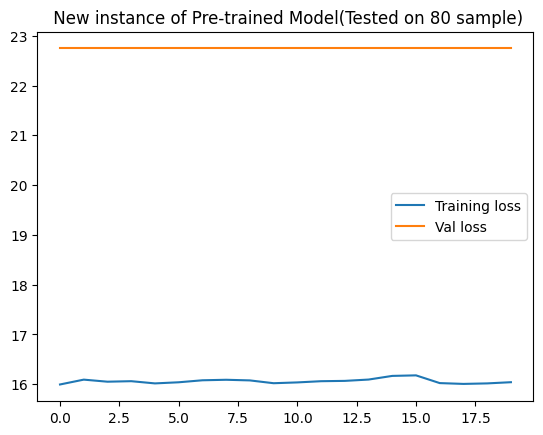

In [34]:
plt.plot(train_histcnnlstm_80, label="Training loss")
plt.plot(val_histcnnlstm_80, label="Val loss")
plt.title(" New instance of Pre-trained Model(Tested on 80 sample)")
plt.legend()